# Banknote authentication
Aim is to develop and evaluate a reliable model for banknote authentication that can accurately distinguish between genuine and counterfeit notes.


In [1]:
# ensure access to mydrive
from google.colab import darive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import libraries
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# define directory where the dataset is stored
dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/banknotes'

In [7]:
# define the image size and channels
img_size = (224, 224)
img_channels = 3


In [14]:
# calculate number of notes in the dataset
real_count = len(os.listdir(os.path.join(dataset_dir, 'real_notes')))
fake_count = len(os.listdir(os.path.join(dataset_dir, 'fake_notes')))
total_count = real_count + fake_count

print('nr of real notes:', real_count)
print('nr of fake notes:', fake_count)
print('total nr of notes:', total_count)

# class balance as percentages
real_pct = real_count / total_count * 100
fake_pct = fake_count / total_count * 100

print(f"Real notes: {real_count} ({real_pct:.2f}%)")
print(f"Fake notes: {fake_count} ({fake_pct:.2f}%)")

nr of real notes: 802
nr of fake notes: 588
total nr of notes: 1390
Real notes: 802 (57.70%)
Fake notes: 588 (42.30%)


### Visual Inspection

Randomly sample and plot a few images from each class (real vs. fake).

Check for:
<br> Color differences (are real notes greener / more faded / higher contrast?)
<br> Visible watermarks or texture differences.
<br> Presence of noise, distortions, or printing patterns.

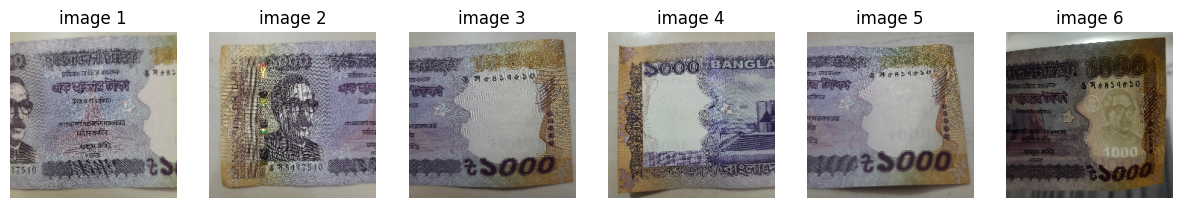

In [8]:
# what an image would look like
image_path = os.path.join(dataset_dir, 'real_notes', 'note_001')
image_files = [
    os.path.join(image_path, file)
    for file in os.listdir(image_path)
    if file.endswith(('.jpg', '.png'))
]
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(image_files):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(image_files), i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"image {i + 1}")
plt.show()


In [26]:
# print random 3 notes
def plot_random_images(folder, num_images):
  image_dir = os.path.join(dataset_dir, folder)
  image_files = []
  for root, _, files in os.walk(image_dir):
      for file in files:
          if file.endswith(('.jpg', '.png')):
              image_files.append(os.path.join(root, file))

  random_images = random.sample(image_files, 3)
  for i, image_path in enumerate(random_images):
      image = cv2.imread(image_path)
      image = cv2.resize(image, img_size)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB in matplotlib
      plt.subplot(1, 3, i + 1)
      plt.imshow(image)
      plt.axis('off')
      plt.title(f"{os.path.basename(folder)} {i + 1}")
  plt.show()


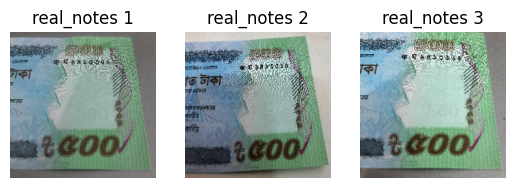

In [27]:
plot_random_images('real_notes', 3)

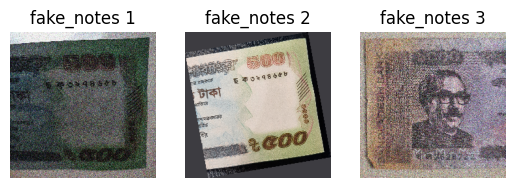

In [28]:
plot_random_images('fake_notes', 3)

### Image Statistics
<br> mean pixel intensity, std deviation, color channel distribution (RGB histograms).

In [33]:
def load_images(folder, n=None, img_size=(224,224)):
    image_dir = os.path.join(dataset_dir, folder)
    image_files = []

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    if len(image_files) == 0:
        print(f"No image files found in folder: {image_dir}")
        return np.array([])

    print(f"Found {len(image_files)} image(s) in folder: {folder}")

    if n is not None:
        image_files = random.sample(image_files, min(n, len(image_files)))

    images = []
    for path in image_files:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: could not read image: {path}")
            continue
        img = cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2RGB)
        images.append(img)

    print(f"Loaded {len(images)} image(s) from folder: {folder}")
    return np.array(images)

# For analysis
real_images = load_images('real_notes', n=50)
fake_images = load_images('fake_notes', n=50)

print("Real images shape:", real_images.shape)
print("Fake images shape:", fake_images.shape)

# Mean RGB per class
real_means = np.mean(real_images, axis=(0,1,2))
fake_means = np.mean(fake_images, axis=(0,1,2))

print("Mean RGB across real notes:", real_means)
print("Mean RGB across fake notes:", fake_means)

Found 4812 image(s) in folder: real_notes
Loaded 50 image(s) from folder: real_notes
Found 3528 image(s) in folder: fake_notes
Loaded 50 image(s) from folder: fake_notes
Real images shape: (50, 224, 224, 3)
Fake images shape: (50, 224, 224, 3)
Mean RGB across real notes: [125.22848613 124.11068479 118.68949577]
Mean RGB across fake notes: [127.8275558  134.75372848 135.4632677 ]


### Texture & Edge Features
<br> filters (Sobel, Laplacian, Gabor) to see if fake notes differ in texture/edges.
<br> Fakes often differ in fine print details.

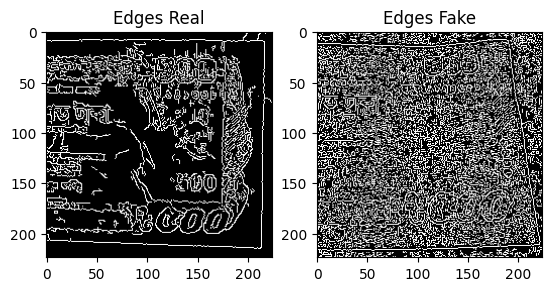

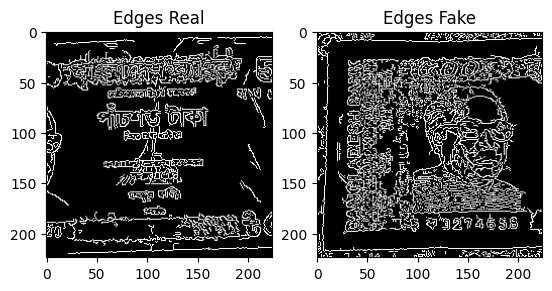

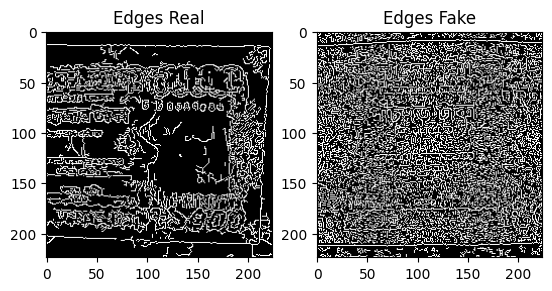

In [41]:
num = 5

for i in range(3):
    edges_real = cv2.Canny(real_images[i], 100, 200)
    edges_fake = cv2.Canny(fake_images[i], 100, 200)

    plt.subplot(1,2,1); plt.imshow(edges_real, cmap='gray'); plt.title("Edges Real")
    plt.subplot(1,2,2); plt.imshow(edges_fake, cmap='gray'); plt.title("Edges Fake")
    plt.show()